# UCF-Crime Anomaly Detection with DenseNet121
Implementation based on 'An investigation of videos for abnormal behavior detection' (Patwal et al., 2023)

---

## 1. Imports

In [24]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    auc, 
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(12)
np.random.seed(12)
if torch.cuda.is_available():
    torch.cuda.manual_seed(12)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 SUPER


## 2. Configuration
Set up paths and hyperparameters according to the paper

In [25]:
# Data directories - UPDATE THESE TO YOUR PATHS
train_root = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Train"
test_root = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Test"
val_root = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2\Validation"
output_dir = r"C:\Users\Brandon\Documents\DM_Project\output\densenet"

os.makedirs(output_dir, exist_ok=True)

# Hyperparameters from the paper
config = {
    'seed': 12,
    'dropout': 0.4,
    'learning_rate': 0.1,
    'batch_size': 4,
    'num_epochs': 50,
    'num_frames': 16,  # Number of frames to sample per video
    'frame_size': 224,  # Input size for DenseNet
    'early_stopping_patience': 10,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Configuration: {config}")

Configuration: {'seed': 12, 'dropout': 0.4, 'learning_rate': 0.1, 'batch_size': 4, 'num_epochs': 50, 'num_frames': 16, 'frame_size': 224, 'early_stopping_patience': 10, 'device': device(type='cuda')}


## 3. Dataset Verification

In [26]:
def count_videos(root_dir):
    """Count videos in each class directory"""
    total = 0
    class_counts = {}
    for cls in sorted(os.listdir(root_dir)):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        num_videos = sum(
            1 for file in os.listdir(cls_path)
            if file.lower().endswith('.mp4')
        )
        class_counts[cls] = num_videos
        print(f"{cls}: {num_videos} videos")
        total += num_videos
    return total, class_counts

print("Training data:")
train_count, train_class_counts = count_videos(train_root)
print(f"\nValidation data:")
val_count, val_class_counts = count_videos(val_root)
print(f"\nTest data:")
test_count, test_class_counts = count_videos(test_root)

print(f"\n=== Total Statistics ===")
print(f"Total Train videos: {train_count}")
print(f"Total Validation videos: {val_count}")
print(f"Total Test videos: {test_count}")

Training data:
Abuse: 40 videos
Arrest: 40 videos
Arson: 40 videos
Assault: 40 videos
Burglary: 80 videos
Explosion: 40 videos
Fighting: 40 videos
NormalVideos: 170 videos
RoadAccidents: 120 videos
Robbery: 120 videos
Shooting: 40 videos
Shoplifting: 40 videos
Stealing: 80 videos
Vandalism: 40 videos

Validation data:
Abuse: 5 videos
Arrest: 5 videos
Arson: 5 videos
Assault: 5 videos
Burglary: 10 videos
Explosion: 5 videos
Fighting: 5 videos
NormalVideos: 19 videos
RoadAccidents: 15 videos
Robbery: 15 videos
Shooting: 5 videos
Shoplifting: 5 videos
Stealing: 10 videos
Vandalism: 5 videos

Test data:
Abuse: 5 videos
Arrest: 5 videos
Arson: 5 videos
Assault: 5 videos
Burglary: 10 videos
Explosion: 5 videos
Fighting: 5 videos
NormalVideos: 150 videos
RoadAccidents: 15 videos
Robbery: 15 videos
Shooting: 5 videos
Shoplifting: 5 videos
Stealing: 10 videos
Vandalism: 5 videos

=== Total Statistics ===
Total Train videos: 930
Total Validation videos: 114
Total Test videos: 245


## 4. Class Labels

In [27]:
# Get class labels
class_labels = sorted(os.listdir(train_root))
num_classes = len(class_labels)
label2id = {label: idx for idx, label in enumerate(class_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Number of classes: {num_classes}")
print(f"\nClass mapping:")
for label, idx in label2id.items():
    print(f"  {idx}: {label}")

Number of classes: 14

Class mapping:
  0: Abuse
  1: Arrest
  2: Arson
  3: Assault
  4: Burglary
  5: Explosion
  6: Fighting
  7: NormalVideos
  8: RoadAccidents
  9: Robbery
  10: Shooting
  11: Shoplifting
  12: Stealing
  13: Vandalism


## 5. Custom Dataset Class
Frame-based approach: Extract frames from videos and treat each frame as a sample

In [28]:
class UCFCrimeFrameDataset(Dataset):
    """
    Dataset that extracts frames from videos for DenseNet.
    Each video is sampled to extract a fixed number of frames.
    """
    def __init__(self, root_dir, label2id, transform=None, num_frames=16):
        self.root_dir = root_dir
        self.label2id = label2id
        self.transform = transform
        self.num_frames = num_frames
        self.samples = []
        
        # Collect all video paths
        for class_name in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            
            label_id = label2id[class_name]
            for video_file in os.listdir(class_path):
                if video_file.lower().endswith('.mp4'):
                    video_path = os.path.join(class_path, video_file)
                    self.samples.append((video_path, label_id))
        
        print(f"Loaded {len(self.samples)} videos")
    
    def __len__(self):
        return len(self.samples)
    
    def extract_frames(self, video_path):
        """Extract uniformly sampled frames from video"""
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")
        
        # Get total frames
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames == 0:
            cap.release()
            raise ValueError(f"No frames in video: {video_path}")
        
        # Uniformly sample frame indices
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        
        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        
        cap.release()
        
        if len(frames) == 0:
            raise ValueError(f"No frames extracted from: {video_path}")
        
        return frames
    
    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        
        try:
            # Extract frames
            frames = self.extract_frames(video_path)
            
            # Apply transforms to each frame
            if self.transform:
                frames = [self.transform(Image.fromarray(frame)) for frame in frames]
            else:
                frames = [torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0 
                         for frame in frames]
            
            # Stack frames: (num_frames, C, H, W)
            frames_tensor = torch.stack(frames)
            
            return frames_tensor, label
            
        except Exception as e:
            print(f"Error loading {video_path}: {e}")
            # Return dummy data in case of error
            dummy_frames = torch.zeros(self.num_frames, 3, 224, 224)
            return dummy_frames, label

## 6. Data Transforms
Using ImageNet normalization for DenseNet

In [29]:
# ImageNet normalization (DenseNet was pretrained on ImageNet)
train_transform = transforms.Compose([
    transforms.Resize((config['frame_size'], config['frame_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((config['frame_size'], config['frame_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms created successfully")

Transforms created successfully


## 7. Create Datasets and DataLoaders

In [30]:
print("Creating datasets...")
train_dataset = UCFCrimeFrameDataset(
    train_root, 
    label2id, 
    transform=train_transform,
    num_frames=config['num_frames']
)

val_dataset = UCFCrimeFrameDataset(
    val_root, 
    label2id, 
    transform=test_transform,
    num_frames=config['num_frames']
)

test_dataset = UCFCrimeFrameDataset(
    test_root, 
    label2id, 
    transform=test_transform,
    num_frames=config['num_frames']
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} videos")
print(f"  Validation: {len(val_dataset)} videos")
print(f"  Test: {len(test_dataset)} videos")

Creating datasets...
Loaded 930 videos
Loaded 114 videos
Loaded 245 videos

Dataset sizes:
  Train: 930 videos
  Validation: 114 videos
  Test: 245 videos


In [31]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders created successfully")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

DataLoaders created successfully
Train batches: 233
Validation batches: 29
Test batches: 62


## 8. DenseNet121 Model
Following the paper's architecture with DenseNet121 as feature extractor

In [32]:
class DenseNetVideoClassifier(nn.Module):
    """
    DenseNet121-based video classifier.
    Processes each frame independently, then aggregates predictions.
    """
    def __init__(self, num_classes, dropout=0.4, pretrained=True):
        super(DenseNetVideoClassifier, self).__init__()
        
        # Load pretrained DenseNet121
        self.densenet = models.densenet121(pretrained=pretrained)
        
        # Get number of features from DenseNet
        num_features = self.densenet.classifier.in_features
        
        # Replace classifier with custom head
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_classes)
        )
        
    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_frames, C, H, W)
        Returns:
            logits: Tensor of shape (batch_size, num_classes)
        """
        batch_size, num_frames, C, H, W = x.shape
        
        # Reshape to process all frames together
        x = x.view(batch_size * num_frames, C, H, W)
        
        # Extract features and classify each frame
        frame_logits = self.densenet(x)  # (batch_size * num_frames, num_classes)
        
        # Reshape back
        frame_logits = frame_logits.view(batch_size, num_frames, -1)
        
        # Aggregate predictions across frames (mean pooling)
        video_logits = torch.mean(frame_logits, dim=1)
        
        return video_logits

# Initialize model
model = DenseNetVideoClassifier(
    num_classes=num_classes,
    dropout=config['dropout'],
    pretrained=True
).to(config['device'])

print(f"Model created and moved to {config['device']}")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model created and moved to cuda

Model architecture:
DenseNetVideoClassifier(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _

## 9. Training Setup
Loss function, optimizer, and learning rate scheduler

In [33]:
# Loss function - Categorical Cross Entropy (as mentioned in the paper)
criterion = nn.CrossEntropyLoss()

# Optimizer - SGD (as mentioned in the paper)
optimizer = optim.SGD(
    model.parameters(),
    lr=config['learning_rate'],
    momentum=0.9,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5
)

print("Training setup complete")
print(f"Optimizer: SGD with lr={config['learning_rate']}")
print(f"Loss function: CrossEntropyLoss")
print(f"Scheduler: ReduceLROnPlateau")

Training setup complete
Optimizer: SGD with lr=0.1
Loss function: CrossEntropyLoss
Scheduler: ReduceLROnPlateau


## 10. Training Functions

In [34]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for frames, labels in pbar:
        frames = frames.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(frames)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for frames, labels in pbar:
            frames = frames.to(device)
            labels = labels.to(device)
            
            outputs = model(frames)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': running_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("Training functions defined")

Training functions defined


## 11. Training Loop
Train the model with early stopping

In [35]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = os.path.join(output_dir, 'best_densenet_model.pth')

print(f"Starting training for {config['num_epochs']} epochs...")
print(f"Early stopping patience: {config['early_stopping_patience']} epochs\n")

for epoch in range(config['num_epochs']):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{config['num_epochs']}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, config['device']
    )
    
    # Validate
    val_loss, val_acc = validate(
        model, val_loader, criterion, config['device']
    )
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, best_model_path)
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")
        
        if epochs_no_improve >= config['early_stopping_patience']:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best model saved to: {best_model_path}")
print(f"{'='*60}")

Starting training for 50 epochs...
Early stopping patience: 10 epochs


Epoch 1/50


Validation: 100%|██████████| 29/29 [00:31<00:00,  1.08s/it, loss=4.39, acc=13.2]



Epoch 1 Summary:
  Train Loss: 4.8495 | Train Acc: 12.37%
  Val Loss:   4.3864 | Val Acc:   13.16%
  ✓ New best model saved! (Val Acc: 13.16%)

Epoch 2/50


Validation: 100%|██████████| 29/29 [00:29<00:00,  1.03s/it, loss=6.94, acc=20.2]



Epoch 2 Summary:
  Train Loss: 2.6520 | Train Acc: 12.04%
  Val Loss:   6.9367 | Val Acc:   20.18%
  ✓ New best model saved! (Val Acc: 20.18%)

Epoch 3/50


Validation: 100%|██████████| 29/29 [00:26<00:00,  1.08it/s, loss=3.73, acc=16.7]



Epoch 3 Summary:
  Train Loss: 2.5856 | Train Acc: 14.84%
  Val Loss:   3.7329 | Val Acc:   16.67%
  No improvement for 1 epoch(s)

Epoch 4/50


Training:  24%|██▍       | 56/233 [01:04<03:24,  1.16s/it, loss=2.57, acc=17]  


KeyboardInterrupt: 

## 12. Plot Training History

Training history plot saved to: C:\Users\Brandon\Documents\DM_Project\output\densenet\training_history.png


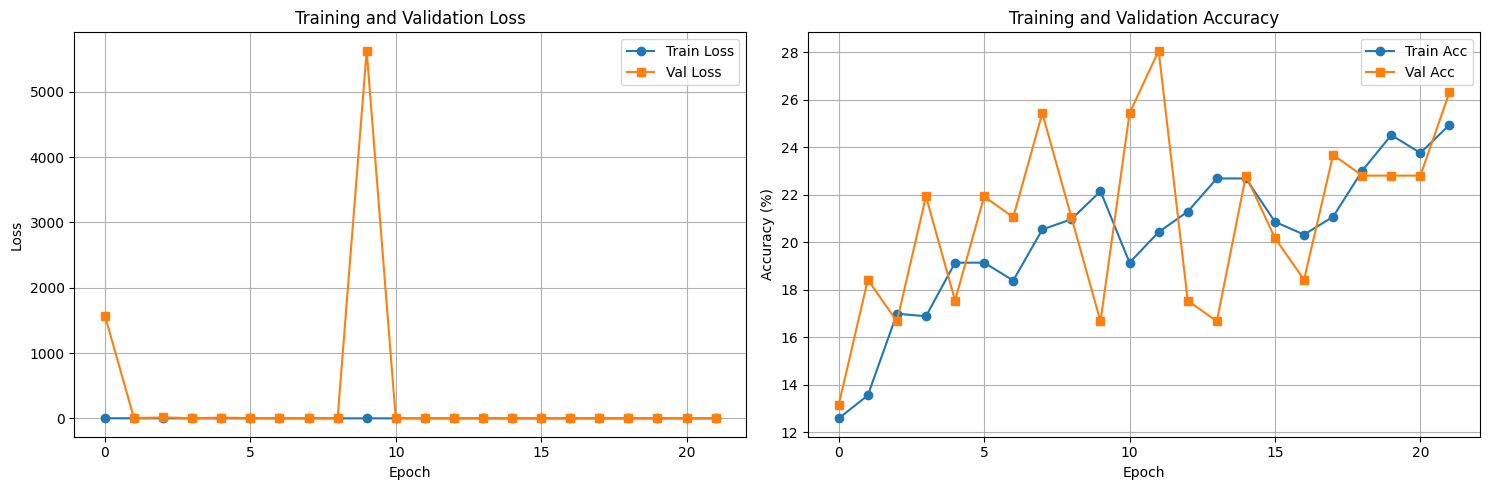

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
history_plot_path = os.path.join(output_dir, 'training_history.png')
plt.savefig(history_plot_path, dpi=300, bbox_inches='tight')
print(f"Training history plot saved to: {history_plot_path}")
plt.show()

## 13. Load Best Model for Evaluation

In [ ]:
# Load the best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

Loaded best model from epoch 12
Best validation accuracy: 28.07%


## 14. Test Set Evaluation
Comprehensive evaluation with confusion matrix and classification report

In [ ]:
def evaluate_model(model, dataloader, device):
    """Evaluate model and return predictions and labels"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for frames, labels in tqdm(dataloader, desc='Evaluating'):
            frames = frames.to(device)
            labels = labels.to(device)
            
            outputs = model(frames)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("Evaluating on test set...")
test_preds, test_labels, test_probs = evaluate_model(model, test_loader, config['device'])

# Calculate accuracy
test_accuracy = 100 * np.sum(test_preds == test_labels) / len(test_labels)
print(f"\n{'='*60}")
print(f"Test Set Accuracy: {test_accuracy:.2f}%")
print(f"{'='*60}")

Evaluating on test set...


Evaluating: 100%|██████████| 62/62 [01:07<00:00,  1.09s/it]


Test Set Accuracy: 27.35%


## 15. Confusion Matrix

Confusion matrix saved to: C:\Users\Brandon\Documents\DM_Project\output\densenet\confusion_matrix.png


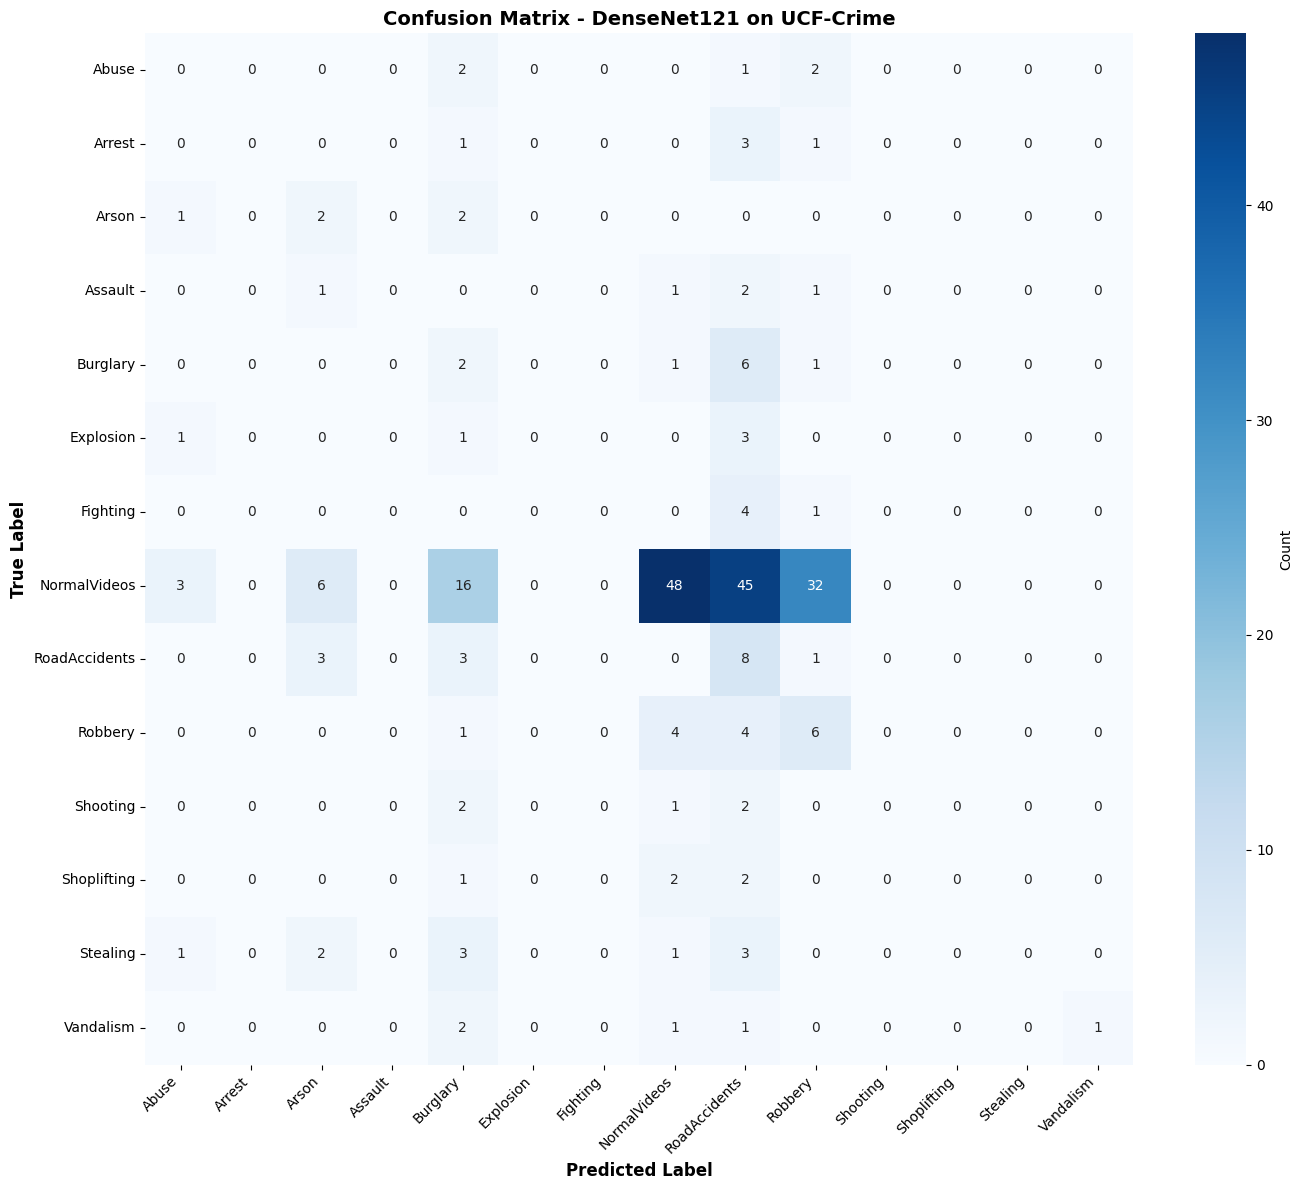

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - DenseNet121 on UCF-Crime', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to: {cm_path}")
plt.show()

## 16. Classification Report

In [ ]:
# Generate classification report
report = classification_report(
    test_labels,
    test_preds,
    target_names=class_labels,
    digits=4
)

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(report)

# Save report to file
report_path = os.path.join(output_dir, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write("Classification Report - DenseNet121 on UCF-Crime\n")
    f.write("="*60 + "\n")
    f.write(f"Test Accuracy: {test_accuracy:.2f}%\n\n")
    f.write(report)
print(f"\nClassification report saved to: {report_path}")


Classification Report:
               precision    recall  f1-score   support

        Abuse     0.0000    0.0000    0.0000         5
       Arrest     0.0000    0.0000    0.0000         5
        Arson     0.1429    0.4000    0.2105         5
      Assault     0.0000    0.0000    0.0000         5
     Burglary     0.0556    0.2000    0.0870        10
    Explosion     0.0000    0.0000    0.0000         5
     Fighting     0.0000    0.0000    0.0000         5
 NormalVideos     0.8136    0.3200    0.4593       150
RoadAccidents     0.0952    0.5333    0.1616        15
      Robbery     0.1333    0.4000    0.2000        15
     Shooting     0.0000    0.0000    0.0000         5
  Shoplifting     0.0000    0.0000    0.0000         5
     Stealing     0.0000    0.0000    0.0000        10
    Vandalism     1.0000    0.2000    0.3333         5

     accuracy                         0.2735       245
    macro avg     0.1600    0.1467    0.1037       245
 weighted avg     0.5377    0.2735    0

## 17. ROC Curves and AUC Scores
Calculate AUC for each class (multi-class ROC)

In [ ]:
# Binarize labels for multi-class ROC
test_labels_bin = label_binarize(test_labels, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"\n{'='*60}")
print("AUC Scores by Class:")
print(f"{'='*60}")
for i, label in enumerate(class_labels):
    print(f"{label:20s}: {roc_auc[i]:.4f}")
print(f"\n{'Macro-Average AUC':20s}: {roc_auc['macro']:.4f}")
print(f"{'='*60}")


AUC Scores by Class:
Abuse               : 0.5817
Arrest              : 0.5133
Arson               : 0.9233
Assault             : 0.4967
Burglary            : 0.6285
Explosion           : 0.6642
Fighting            : 0.4400
NormalVideos        : 0.6778
RoadAccidents       : 0.6783
Robbery             : 0.6759
Shooting            : 0.7300
Shoplifting         : 0.5183
Stealing            : 0.4449
Vandalism           : 0.7733

Macro-Average AUC   : 0.6275


## 18. Plot Multi-Class ROC Curves

ROC curves saved to: C:\Users\Brandon\Documents\DM_Project\output\densenet\roc_curves.png


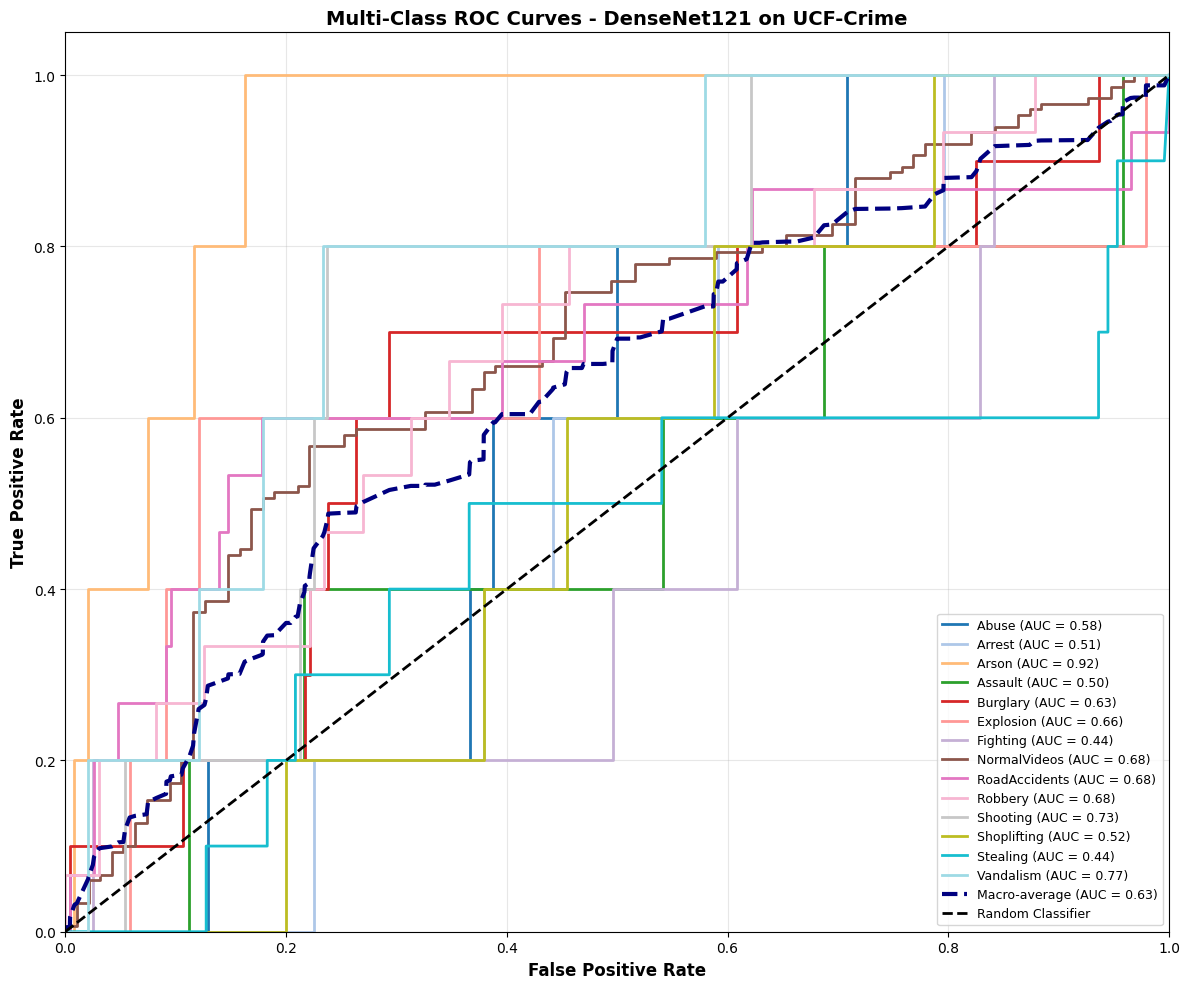

In [ ]:
# Plot ROC curves
plt.figure(figsize=(12, 10))

# Plot ROC curve for each class
colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, num_classes))
for i, color in zip(range(num_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})'
    )

# Plot macro-average ROC curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    color='navy',
    linestyle='--',
    linewidth=3,
    label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})'
)

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Multi-Class ROC Curves - DenseNet121 on UCF-Crime', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

roc_path = os.path.join(output_dir, 'roc_curves.png')
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f"ROC curves saved to: {roc_path}")
plt.show()